# LightFM -  hybrid matrix factorisation on MovieLens (Python, CPU)

This notebook explains the concept of a hybrid matrix factorisation based model for recommendation, it also outlines the steps to construct a pure matrix factorisation and a hybrid models using the [LightFM](https://github.com/lyst/lightfm) package. It also demonstrates how to extract both user and item affinity from a fitted hybrid model.

## 1. Hybrid matrix factorisation model

### 1.1 Background

In general, most recommendation models can be divided into two categories:
- Content based model,
- Collaborative filtering model.

The content-based model recommends based on similarity of the items and/or users using their description/metadata/profile. On the other hand, collaborative filtering model (discussion is limited to matrix factorisation approach in this notebook) computes the latent factors of the users and items. It works based on the assumption that if a group of people expressed similar opinions on an item, these peole would tend to have similar opinions on other items. For further background and detailed explanation between these two approaches, the reader can refer to machine learning literatures [3, 4].

The choice between the two models is largely based on the data availability. For example, the collaborative filtering model is usually adopted and effective when sufficient ratings/feedbacks have been recorded for a group of users and items.

However, if there is a lack of ratings, content based model can be used provided that the metadata of the users and items are available. This is also the common approach to address the cold-start issues, where there are insufficient historical collaborative interactions available to model new users and/or items.

<!-- In addition, most collaborative filtering models only consume explicit ratings e.g. movie 

**NOTE** add stuff about implicit and explicit ratings -->

### 1.2 Hybrid matrix factorisation algorithm

In view of the above problems, there have been a number of proposals to address the cold-start issues by combining both content-based and collaborative filtering approaches. The hybrid matrix factorisation model is among one of the solutions proposed [1].  

In general, most hybrid approaches proposed different ways of assessing and/or combining the feature data in conjunction with the collaborative information.

### 1.3 LightFM package 

LightFM is a Python implementation of a hybrid recommendation algorithms for both implicit and explicit feedbacks [1].

It is a hybrid content-collaborative model which represents users and items as linear combinations of their content features’ latent factors. The model learns **embeddings or latent representations of the users and items in such a way that it encodes user preferences over items**. These representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

The user and item embeddings are estimated for every feature, and these features are then added together to be the final representations for users and items. 

For example, for user i, the model retrieves the i-th row of the feature matrix to find the features with non-zero weights. The embeddings for these features will then be added together to become the user representation e.g. if user 10 has weight 1 in the 5th column of the user feature matrix, and weight 3 in the 20th column, the user 10’s representation is the sum of embedding for the 5th and the 20th features multiplying their corresponding weights. The representation for each items is computed in the same approach. 

#### 1.3.1 Modelling approach

Let $U$ be the set of users and $I$ be the set of items, and each user can be described by a set of user features $f_{u} \subset F^{U}$ whilst each items can be described by item features $f_{i} \subset F^{I}$. Both $F^{U}$ and $F^{I}$ are all the features which fully describe all users and items. 

The LightFM model operates based binary feedbacks, the ratings will be normalised into two groups. The user-item interaction pairs $(u,i) \in U\times I$ are the union of positive (favourable reviews) $S^+$ and negative interactions (negative reviews) $S^-$ for explicit ratings. For implicit feedbacks, these can be the observed and not observed interactions respectively.

For each user and item feature, their embeddings are $e_{f}^{U}$ and $e_{f}^{I}$ respectively. Furthermore, each feature is also has a scalar bias term ($b_U^f$ for user and $b_I^f$ for item features). The embedding (latent representation) of user $u$ and item $i$ are the sum of its respective features’ latent vectors:

$$ 
q_{u} = \sum_{j \in f_{u}} e_{j}^{U}
$$

$$
p_{i} = \sum_{j \in f_{i}} e_{j}^{I}
$$

Similarly the biases for user $u$ and item $i$ are the sum of its respective bias vectors. These variables capture the variation in behaviour across users and items:

$$
b_{u} = \sum_{j \in f_{u}} b_{j}^{U}
$$

$$
b_{i} = \sum_{j \in f_{i}} b_{j}^{I}
$$

In LightFM, the representation for each user/item is a linear weighted sum of its feature vectors.

The prediction for user $u$ and item $i$ can be modelled as sigmoid of the dot product of user and item vectors, adjusted by its feature biases as follows:

$$
\hat{r}_{ui} = \sigma (q_{u} \cdot p_{i} + b_{u} + b_{i})
$$

As the LightFM is constructed to predict binary outcomes e.g. $S^+$ and $S^-$, the function $\sigma()$ is based on the [sigmoid function](https://mathworld.wolfram.com/SigmoidFunction.html). 

The LightFM algorithm estimates interaction latent vectors and bias for features. For model fitting, the cost function of the model consists of maximising the likelihood of data conditional on the parameters described above using stochastic gradient descent. The likelihood can be expressed as follows:

$$
L = \prod_{(u,i) \in S+}\hat{r}_{ui} \times \prod_{(u,i) \in S-}1 - \hat{r}_{ui}
$$

Note that if the feature latent vectors are not available, the algorithm will behaves like a [logistic matrix factorisation model](http://stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf).

### 2.1 Import libraries

In [21]:
import sys

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scrapbook as sb
from tqdm import tqdm

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics

from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import auc_score


print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.11.2 (v3.11.2:878ead1ac1, Feb  7 2023, 10:02:41) [Clang 13.0.0 (clang-1300.0.29.30)]
LightFM version: 1.17


### 2.2 Defining variables

In [22]:
# default number of recommendations
K = 20
# percentage of data used for testing
TEST_PERCENTAGE = 0.2
# model learning rate
LEARNING_RATE = 0.01
# no of latent factors
NO_COMPONENTS = 200
# no of epochs to fit model
NO_EPOCHS = 100
# no of threads to fit model
NO_THREADS = 16
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 42

### 2.2 Retrieve data

In [23]:
data = pd.read_csv('../data/interim/100k_clean.csv', index_col=0)
data

,user id,item id,rating,genre,gender,occupation,age_group
0,1,168,5,Comedy,M,technician,adults
1,1,172,5,"Action, Adventure, Drama, Romance, Sci-Fi, War",M,technician,adults
2,1,165,5,Drama,M,technician,adults
3,1,156,4,"Crime, Thriller",M,technician,adults
4,1,196,5,Drama,M,technician,adults
...,...,...,...,...,...,...,...
99995,943,449,1,"Action, Adventure, Sci-Fi",M,student,adults
99996,943,229,2,"Action, Adventure, Sci-Fi",M,student,adults
99997,943,230,1,"Action, Adventure, Sci-Fi",M,student,adults
99998,943,228,3,"Action, Adventure, Sci-Fi",M,student,adults


## **Preprocessing**

In [24]:
data = data[data['rating'] > 3]
data

,user id,item id,rating,genre,gender,occupation,age_group
0,1,168,5,Comedy,M,technician,adults
1,1,172,5,"Action, Adventure, Drama, Romance, Sci-Fi, War",M,technician,adults
2,1,165,5,Drama,M,technician,adults
3,1,156,4,"Crime, Thriller",M,technician,adults
4,1,196,5,Drama,M,technician,adults
...,...,...,...,...,...,...,...
99981,943,1074,4,"Comedy, Drama",M,student,adults
99984,943,41,4,Comedy,M,student,adults
99989,943,237,4,"Drama, Romance",M,student,adults
99991,943,151,4,"Adventure, Children's, Comedy",M,student,adults


In [25]:
item_cols = ['genre']

user_cols = ['gender', 'occupation', 'age_group']


all_item_features = list(set(itertools.chain.from_iterable([x.split(', ') for x in data['genre']])))
all_user_features = np.concatenate([data[col].unique() for col in user_cols]).tolist()

In [26]:
print(all_item_features)
print(all_user_features)

['Fantasy', 'Animation', 'Action', 'Thriller', 'Western', 'Musical', 'Comedy', 'War', 'Sci-Fi', 'Drama', 'Film-Noir', 'Mystery', 'Adventure', 'Documentary', 'unknown', 'Crime', 'Horror', "Children's", 'Romance']
['M', 'F', 'technician', 'other', 'writer', 'executive', 'administrator', 'student', 'lawyer', 'educator', 'scientist', 'entertainment', 'programmer', 'librarian', 'homemaker', 'artist', 'engineer', 'marketing', 'none', 'healthcare', 'retired', 'salesman', 'doctor', 'adults', 'old adults', 'middle age', 'child', 'teenage']


### 2.3 Prepare data

Before fitting the LightFM model, we need to create an instance of `Dataset` which holds the interaction matrix.

In [27]:
dataset = Dataset()

The `fit` method creates the user/item id mappings.

In [28]:
dataset.fit(
    users=data['user id'], 
    items=data['item id'],
    user_features=all_user_features,
    item_features=all_item_features
)

# quick check to determine the number of unique users and items in the data
num_users, num_items = dataset.interactions_shape()
print(f'Num users: {num_users}, num_items: {num_items}.')

Num users: 942, num_items: 1447.


In [29]:
(interactions, weights) = dataset.build_interactions(zip(data['user id'], data['item id']))

In [30]:
def item_feature_generator():
    for i, row in data.iterrows():
        features = row['genre'].split(', ')
        yield (row['item id'], features)

def user_feature_generator():
    for i, row in data.iterrows():
        features = [row[column] for column in user_cols]
        yield (row['user id'], features)

In [31]:
item_features = dataset.build_item_features((item_id, item_feature) for item_id, item_feature in item_feature_generator())
user_features = dataset.build_user_features((user_id, user_feature) for user_id, user_feature in user_feature_generator())

Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [32]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED)
)

Extract indicies of test data 

(shuffle with the same SEED actually returns the same indicies, as it did in random_train_test_split, otherwise we can't get indicies)

In [33]:
uids, iids, data_interaction = cross_validation._shuffle(interactions.row, interactions.col, interactions.data, np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)
train_idx = slice(None, cutoff)

test_uids, test_iids = uids[test_idx], iids[test_idx]
train_uids, train_iids = uids[train_idx], iids[train_idx]

Double check the size of both the train and test sets.

In [34]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (942, 1447)
Shape of test interactions: (942, 1447)


In [35]:
def calculate_metrics(model, interactions, item_features, user_features, k):
    precision = precision_at_k(model, interactions, item_features=item_features, user_features=user_features, k=k).mean()
    recall = recall_at_k(model, interactions, item_features=item_features, user_features=user_features, k=k).mean()
    auc = auc_score(model, interactions, item_features=item_features, user_features=user_features).mean()
    return precision, recall, auc

### 2.4 Fit the LightFM model

In this notebook, the LightFM model will be using the weighted Approximate-Rank Pairwise (WARP) as the loss. Further explanation on the topic can be found [here](https://making.lyst.com/lightfm/docs/examples/warp_loss.html#learning-to-rank-using-the-warp-loss).


In general, it maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present.

In [36]:
model = LightFM(
    loss='warp', 
    no_components=NO_COMPONENTS, 
    learning_rate=LEARNING_RATE,
    random_state=np.random.RandomState(SEED)
)

The LightFM model can be fitted with the following code:

Unfortunately loss can't be tracked :(

In [37]:
train_history = {
    'AUC': [],
    'Precision': [],
    'Recall': [],
}

test_history = {
    'AUC': [],
    'Precision': [],
    'Recall': [],
}

for epoch in range(NO_EPOCHS):
    
    model.fit_partial(
        interactions=train_interactions,
        user_features=user_features,
        item_features=item_features,
        epochs=1,
        num_threads=NO_THREADS
    )
    
    train_precision, train_recall, train_auc = calculate_metrics(model, train_interactions, item_features, user_features, K)
    test_precision, test_recall, test_auc = calculate_metrics(model, test_interactions, item_features, user_features, K)

    train_history['AUC'].append(train_auc)
    train_history['Precision'].append(train_precision)
    train_history['Recall'].append(train_recall)

    test_history['AUC'].append(test_auc)
    test_history['Precision'].append(test_precision)
    test_history['Recall'].append(test_recall)


    print(f'Epoch {epoch + 1}/{NO_EPOCHS}, Train auc: {train_auc}, Test auc: {test_auc}')

Epoch 1/100, Train auc: 0.7646501064300537, Test auc: 0.757066011428833
Epoch 2/100, Train auc: 0.7822599411010742, Test auc: 0.772692084312439
Epoch 3/100, Train auc: 0.7987033128738403, Test auc: 0.7886555790901184
Epoch 4/100, Train auc: 0.8109918236732483, Test auc: 0.7996947169303894
Epoch 5/100, Train auc: 0.8106657266616821, Test auc: 0.7986981868743896
Epoch 6/100, Train auc: 0.8161460757255554, Test auc: 0.8046464920043945
Epoch 7/100, Train auc: 0.8204139471054077, Test auc: 0.807991623878479
Epoch 8/100, Train auc: 0.8218086957931519, Test auc: 0.8097161054611206
Epoch 9/100, Train auc: 0.8238188028335571, Test auc: 0.8112820386886597
Epoch 10/100, Train auc: 0.8260322213172913, Test auc: 0.813683271408081
Epoch 11/100, Train auc: 0.8284212350845337, Test auc: 0.8154520392417908
Epoch 12/100, Train auc: 0.8309704661369324, Test auc: 0.8181918859481812
Epoch 13/100, Train auc: 0.8312796354293823, Test auc: 0.8182121515274048
Epoch 14/100, Train auc: 0.833284854888916, Test au

### 2.6 Model evaluation

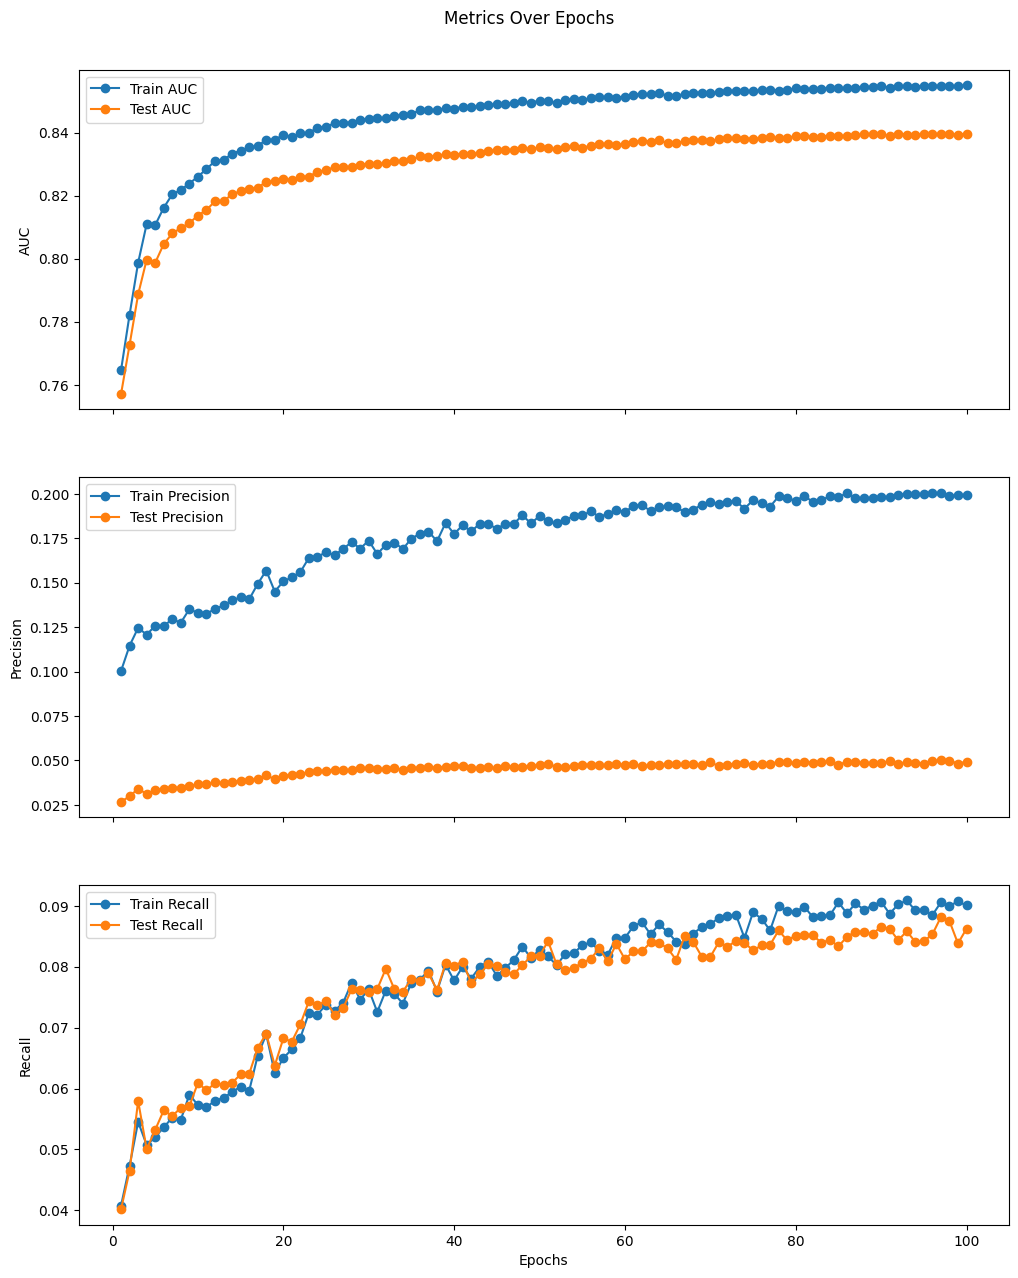

In [38]:
import matplotlib.pyplot as plt

# Assuming train_history and test_history are dictionaries with 'AUC', 'Precision', and 'Recall' keys

epochs = range(1, NO_EPOCHS + 1)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Plot AUC
axs[0].plot(epochs, train_history['AUC'], label='Train AUC', marker='o')
axs[0].plot(epochs, test_history['AUC'], label='Test AUC', marker='o')
axs[0].set_ylabel('AUC')
axs[0].legend()

# Plot Precision
axs[1].plot(epochs, train_history['Precision'], label='Train Precision', marker='o')
axs[1].plot(epochs, test_history['Precision'], label='Test Precision', marker='o')
axs[1].set_ylabel('Precision')
axs[1].legend()

# Plot Recall
axs[2].plot(epochs, train_history['Recall'], label='Train Recall', marker='o')
axs[2].plot(epochs, test_history['Recall'], label='Test Recall', marker='o')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Recall')
axs[2].legend()

plt.suptitle('Metrics Over Epochs', y=0.92)
plt.show()


The performance of the model will be tracked using both Precision@K and Recall@K.

In [39]:
# Evaluate precision at k on the test data
precision = precision_at_k(model, test_interactions, item_features=item_features, user_features=user_features, k=K).mean()
recall = recall_at_k(model, test_interactions, item_features=item_features, user_features=user_features, k=K).mean()

train_auc = auc_score(model, train_interactions, item_features=item_features, user_features=user_features).mean()
test_auc = auc_score(model, test_interactions, item_features=item_features, user_features=user_features).mean()

print(f'Precision at {K}: {precision}')
print(f'Recall at {K}: {recall}')
print(f'train AUC: {train_auc}')
print(f'test AUC: {test_auc}')

Precision at 20: 0.04929424822330475
Recall at 20: 0.08623487475585179
train AUC: 0.8550326228141785
test AUC: 0.8395867347717285


Let's see recommendation on example

In [53]:
item_columns = ['item id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
                'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

item = pd.read_csv('../data/raw/ml-100k/u.item', sep='|', header=None, encoding='latin-1', names=item_columns)

genre_columns = item.columns.values[2:]
item['genre'] = item[genre_columns].apply(lambda row: ', '.join(row.index[row == 1]), axis=1)
item.drop(genre_columns, axis=1, inplace=True)

film_names = item[['item id', 'movie_title', 'genre']]
film_names

,item id,movie_title,genre
0,1,Toy Story (1995),"Animation, Children's, Comedy"
1,2,GoldenEye (1995),"Action, Adventure, Thriller"
2,3,Four Rooms (1995),Thriller
3,4,Get Shorty (1995),"Action, Comedy, Drama"
4,5,Copycat (1995),"Crime, Drama, Thriller"
...,...,...,...
1677,1678,Mat' i syn (1997),Drama
1678,1679,B. Monkey (1998),"Romance, Thriller"
1679,1680,Sliding Doors (1998),"Drama, Romance"
1680,1681,You So Crazy (1994),Comedy


In [55]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [127]:
def sample_recommendation(model, user_ids, k):
    mapper_to_internal_ids = dataset.mapping()[2]
    mapper_to_external_ids = {v: k for k, v in mapper_to_internal_ids.items()}

    user_mapper_to_internal = dataset.mapping()[0]
    user_ids = np.vectorize(user_mapper_to_internal.get)(user_ids)

    for user_id in user_ids:
        print(f'Films watched by user: {user_id}')

        train_item_ids = [iid for uid, iid in zip(train_uids, train_iids) if uid == user_id]

        display_side_by_side(film_names[film_names['item id'].isin(np.vectorize(mapper_to_external_ids.get)(train_item_ids))])

        scores = model.predict(
            int(user_id),
            list(mapper_to_internal_ids.values()),   
            user_features=user_features,
            item_features=item_features
        )
        top_k_indices = np.argsort(-scores)[:k]
        print('Recommended: ')
        display_side_by_side(film_names[film_names['item id'].isin(np.vectorize(mapper_to_external_ids.get)(top_k_indices))])

sample_recommendation(model, [15], k=5)

Films watched by user: 14


,item id,movie_title,genre
8,9,Dead Man Walking (1995),Drama
14,15,Mr. Holland's Opus (1995),Drama
49,50,Star Wars (1977),"Action, Adventure, Romance, Sci-Fi, War"
110,111,"Truth About Cats & Dogs, The (1996)","Comedy, Romance"
136,137,Big Night (1996),Drama
180,181,Return of the Jedi (1983),"Action, Adventure, Romance, Sci-Fi, War"
219,220,"Mirror Has Two Faces, The (1996)","Comedy, Romance"
254,255,My Best Friend's Wedding (1997),"Comedy, Romance"
256,257,Men in Black (1997),"Action, Adventure, Comedy, Sci-Fi"
268,269,"Full Monty, The (1997)",Comedy


Recommended: 


,item id,movie_title,genre
63,64,"Shawshank Redemption, The (1994)",Drama
195,196,Dead Poets Society (1989),Drama
317,318,Schindler's List (1993),"Drama, War"
356,357,One Flew Over the Cuckoo's Nest (1975),Drama
495,496,It's a Wonderful Life (1946),Drama


## References

- [[1](https://arxiv.org/abs/1507.08439)]. Maciej Kula - Metadata Embeddings for User and Item Cold-start Recommendations, 2015. arXiv:1507.08439
- [[2](https://making.lyst.com/lightfm/docs/home.html)]. LightFM documentation,
- [3]. Charu C. Aggarwal - Recommender Systems: The Textbook, Springer, April 2016. ISBN 978-3-319-29659-3
- [4]. Deepak K. Agarwal, Bee-Chung Chen - Statistical Methods for Recommender Systems, 2016. ISBN: 9781107036079 
